***3-Link Open Chain - Block System Simulator***

Here, we will put together all of your coding and math skills to simulate a 3 link open chain 'finger' that makes contact with a cube.

Assumptions:
- The center of mass of each finger link with mass $m_l$ is located at the **joints**, NOT at the center of geometry of each link.
- The cube has uniform density, with overall mass $m_b$
- The cube is constrained to a single (translational) degree of freedom of motion along the world frame x-axis (left and right). This means that the block can't rotate or move up and down.
- Self-collisions between the links of the robot are **not** considered
- Collisions between the block and the end effector are the only contacts considered (other joints will 'phase' through the block and the ground)

In [1]:
try:
    import numpy as np 
    import jax.numpy as jnp
    import jax
    from jax import jit, vmap, jacfwd
    import matplotlib.pyplot as plt 
    from tqdm import tqdm

    # local
    from animation_matplotlib import animate
    from samplers.predictive_sampler import ContactAwarePredictiveSampler as CAPS
except:
    raise Exception('not all packages installed in environment :-(')

**Step 0** Define the physics parameters of the system

In [2]:
dt              = 0.001                                                                             # step size, seconds
l_links         = jnp.array([0.25, 0.25, 0.25])                                                     # meters
m_links         = jnp.array([0.10, 0.10, 0.10])                                                     # kilograms
I_links         = jnp.array([(1.0/12.0)*m_links[i]*(l_links[i]**2+0.001**2) for i in range(3)])     # kg m^2
l_block         = 0.1                                                                               # meters
m_block         = 0.25                                                                              # kilograms
I_block         = 2.0/12.0 * m_block * l_block**2.0                                                 # kg m^2
g               = 9.81                                                                              # m/s^2
q_init          = jnp.array([-0.0521448,  jnp.pi/4.0, jnp.pi/4.0])                                  # initial condition joint angles
qdot_init       = jnp.array([0.0]*3)                                                                # initial condition joint velocities
qblock_init     = jnp.array([0.5,l_block/2.0,0.0])                                                  # initial condition of block position (x-dir,y-dir,rotation)
qblockdot_init  = jnp.array([0.0,0.0,0.0])                                                          # initial condition of block velocity (x-dir,y-dir,rotation)

# goal states for tasks
xblock_goal     = jnp.array([0.75, l_block/2.0, 0.0, 0.0, 0.0, 0.0])                                # full goal state of the block
x_op_space_goal = jnp.array([0.4,0.2])                                                              # end eff goal state for op space ctrl

# joint constraints, torque constraints
q_min, q_max = [-jnp.pi/4.0,-jnp.pi/2.0,-jnp.pi/2.0], [jnp.pi/4.0,jnp.pi/2.0,jnp.pi/2.0]            # joint position limits on robot, rad
qdot_min, qdot_max = [-1.5]*3, [1.5]*3                                                              # joint velocity (angular) limits, rad/s
torque_min, torque_max = [-1.0,-1.0,-1.0], [1.0,1.0,1.0]                                            # torque input limits on joints, N

# define contact model parameters
K_ee_block = 5000.0                                                                                 # end eff to block contact stiffness param, N/m
K_ee_ground = 1.0e8                                                                                 # end eff to ground contact stiffness param, N/m
mu_block_ground = 0.7                                                                               # block to ground friction coeff

# booleans to activate different controllers (CHANGE TO TRUE TO ACTIVATE)
is_opSpace      = True
debugger        = True
is_pushblock    = True

Q_init = {
    'joints': q_init,
    'block': qblock_init
}
Qdot_init = {
    'joints': qdot_init,
    'block': qblockdot_init
}

**Step 1** Write the forward kinematics of the system

In [3]:
def forward_kinematics(Q, Qdot):
    q, qdot = Q['joints'], Qdot['joints']
    # joint positions with respect to the world frame W
    x_1, y_1 = l_links[0]*jnp.sin(q[0]), l_links[0]*jnp.cos(q[0])
    x_2, y_2 = x_1 + l_links[1]*jnp.sin(q[0]+q[1]), y_1 + l_links[1]*jnp.cos(q[0]+q[1])
    x_3, y_3 = x_2 + l_links[2]*jnp.sin(q[0]+q[1]+q[2]), y_2 + l_links[2]*jnp.cos(q[0]+q[1]+q[2])
    # joint (rectangular) velocities with respecto to the world frame W
    xdot_1, ydot_1 = - l_links[0]*qdot[0]*jnp.cos(q[0]), l_links[0]*qdot[0]*jnp.sin(q[0])
    xdot_2, ydot_2 = xdot_1 - l_links[1]*(qdot[0]+qdot[1])*jnp.cos(q[0]+q[1]), ydot_1 + l_links[1]*(qdot[0]+qdot[1])*jnp.sin(q[0]+q[1])
    xdot_3, ydot_3 = xdot_2 - l_links[1]*(qdot[0]+qdot[1]+qdot[2])*jnp.cos(q[0]+q[1]+q[2]), ydot_2 + l_links[1]*(qdot[0]+qdot[1]+qdot[2])*jnp.sin(q[0]+q[1]+q[2])
    return jnp.array([
        (x_1,y_1),
        (x_2,y_2),
        (x_3,y_3)
    ]), jnp.array([
        (xdot_1,ydot_1),
        (xdot_2,ydot_2),
        (xdot_3,ydot_3)
    ])

**Step 2** Define Contact Physics Using the Soft Contact Model

In [4]:
def signed_distance_function_ee_to_block(Q,Qdot):
    # signed distance function
    def softmax(a, b, eps=0.001):
        """
        softmax activation
        """
        return 0.5 * (a + b + jnp.sqrt((a-b)**2 + eps**2))
    def R(angle: float):
        """
        z-Rotation matrix
        """
        return jnp.array([[jnp.cos(angle), -jnp.sin(angle)],
                          [jnp.sin(angle), jnp.cos(angle)]]).reshape((2,2))
    # get joint positions and end eff velocities
    pos, vel = forward_kinematics(Q,Qdot)
    # split up the state vector of box
    qbx, qby, qbphi = jnp.split(Q['block'], 3)
    # sdf vector
    phix, phiy = jnp.split(
        jnp.abs(
        R(-qbphi)@(jnp.hstack(pos[-1]) - jnp.hstack([qbx, qby]))
        ) - jnp.hstack(
            [
                0.5*l_block,
                0.5*l_block
            ]
        ),
        2
    )
    return (softmax(phix,0.0)**2 + softmax(phiy,0.0)**2)**0.5 \
            -softmax(-softmax(phix,phiy),0.0)

def signed_distance_function_ee_to_ground(Q,Qdot):
    # get joint positions and end eff velocities
    pos, vel = forward_kinematics(Q,Qdot)

    return jnp.array([pos[-1,1]])

def get_contact_jac_ee_to_block(Q,Qdot):
    return jacfwd(signed_distance_function_ee_to_block, argnums=0)(Q,Qdot)

def get_contact_jac_ee_to_ground(Q,Qdot):
    return jacfwd(signed_distance_function_ee_to_ground, argnums=0)(Q,Qdot)

def get_contact_force_ee_to_block(Q,Qdot):
    # assuming no contact dampening
    phi_n = signed_distance_function_ee_to_block(Q,Qdot)
    return jnp.maximum(0.0,-K_ee_block*phi_n)

def get_contact_force_ee_to_ground(Q,Qdot):
    # assuming no contact dampening
    phi_n = signed_distance_function_ee_to_ground(Q,Qdot)
    return jnp.maximum(0.0,-K_ee_ground*phi_n)


In [5]:
## test ##
print('sdf_block: ', signed_distance_function_ee_to_block(Q_init,Qdot_init))
print('sdf_ground: ', signed_distance_function_ee_to_ground(Q_init,Qdot_init))
print('contact jacobian block: ', get_contact_jac_ee_to_block(Q_init,Qdot_init))
print('contact jacobian ground: ', get_contact_jac_ee_to_ground(Q_init,Qdot_init))
print('force: ', get_contact_force_ee_to_block(Q_init,Qdot_init))
print('projected ground force: ', get_contact_jac_ee_to_ground(Q_init,Qdot_init)['joints'].T@
      get_contact_force_ee_to_ground(Q_init,Qdot_init))

sdf_block:  [0.35147092]
sdf_ground:  [0.44844073]
contact jacobian block:  {'block': Array([[ 0.1310134 , -0.99137855,  0.04301836]], dtype=float32), 'joints': Array([[-0.4592216 , -0.4394307 , -0.24921489]], dtype=float32)}
contact jacobian ground:  {'block': Array([[0., 0., 0.]], dtype=float32), 'joints': Array([[-0.4039525, -0.4169828, -0.2496602]], dtype=float32)}
force:  [0.]
projected ground force:  [-0. -0. -0.]


**Step 3** Define the Lagrangian of the system.

In [6]:
def Lagrangian(Q,Qdot):
    """
    returns the lagrangian of the finger robot \n
    inputs:
        `Q`[dict]: joint angles and block position in world frame
        `Qdot`[dict]: joint angular velocities and block velocity in world frame
    returns:
        Lagrangian (`T - V`): T includes translational and rotational kinetic energy, V includes only gravitational energy
    """
    ## write code here ##
    pos, vel = forward_kinematics(Q,Qdot)
    T = jnp.sum(jnp.hstack([0.5 * m_links[i] * jnp.sum(vel[i]**2) for i in range(pos.shape[0])])) \
        + jnp.sum(jnp.hstack([0.5*I_links[i]*Qdot['joints'][i]**2 for i in range(Qdot['joints'].shape[0])]))
    V = jnp.sum(jnp.hstack([m_links[i] * g * pos[i,-1] for i in range(pos.shape[0])]))
    
    return T - V

# get mass, coriolis, and gravity matrix functions
Mass_matrix = jit(jacfwd(jacfwd(Lagrangian, argnums=1), argnums=1))
Coriolis_matrix = jit(jacfwd(jacfwd(Lagrangian, argnums=1), argnums=0))
Grav_vector = jit(jacfwd(Lagrangian, argnums=0))

def qddot_finger(Q, Qdot, tau):
    # get contact force and contact jacobians
    _lambda = get_contact_force_ee_to_block(Q,Qdot)
    _lambda_ee_to_ground = get_contact_force_ee_to_block(Q,Qdot)
    jac_lambda = get_contact_jac_ee_to_block(Q,Qdot)['joints']
    jac_lambda_ee_to_ground = get_contact_jac_ee_to_ground(Q,Qdot)['joints']
    
    return jnp.linalg.inv(Mass_matrix(Q,Qdot)['joints']['joints']) @ (tau + 
                                                                      jac_lambda.T@_lambda + 
                                                                      jac_lambda_ee_to_ground.T@_lambda_ee_to_ground +
                                                                      Grav_vector(Q,Qdot)['joints'] - 
                                                                      Coriolis_matrix(Q,Qdot)['joints']['joints']@Qdot['joints'])

def qddot_block(Q, Qdot):
    # get contact force and contact jacobians
    _lambda = get_contact_force_ee_to_block(Q,Qdot)
    jac_lambda = get_contact_jac_ee_to_block(Q,Qdot)['block']
    _lambda_friction = jnp.array([-mu_block_ground*m_block*g*jnp.tanh(jac_lambda@Qdot['block'])])[0]
    Jc_T_lambda_ee_to_block_x =(jac_lambda.T@_lambda)[0]
    Jc_T_lambda_friction = (jac_lambda.T@_lambda_friction)[0]

    return jnp.hstack([m_block**-1 * (Jc_T_lambda_ee_to_block_x + Jc_T_lambda_friction),0.0,0.0])

In [7]:
## test ##
print('lag: ', Lagrangian(Q_init,Qdot_init))
print('qddot_finger: ', qddot_finger(Q_init, Qdot_init, jnp.zeros_like(Q_init['joints'])))
print('qddot_block: ', qddot_block(Q_init, Qdot_init))

lag:  -1.1119747
qddot_finger:  [-12.89474   38.96599   -4.910534]
qddot_block:  [0. 0. 0.]


**Step 3.5** Define functions to control the finger in end-effector space (called Operational Space Control)

In [8]:
def get_xddot_des_finger(x, Kp = 500.0, Kd = 5.0):
    return Kp*(x_op_space_goal - x[:2]) + Kd*(x[2:])

def get_jac_fwd(Q,Qdot):
    # compute jacobian of forward kinematics wrt joint angles
    dpos_dq, _ = jacfwd(forward_kinematics, argnums=0)(Q,Qdot)
    return dpos_dq['joints'][-1]

def get_operational_space_mass_matrix(Q,Qdot):
    jac = get_jac_fwd(Q,Qdot)
    return jnp.linalg.inv(jac@jnp.linalg.inv(Mass_matrix(Q,Qdot)['joints']['joints'])@jac.T)

def get_operational_space_control(Q,Qdot):
    # compute forward kinematics, and get jacobian
    pos, vel = forward_kinematics(Q,Qdot)
    jac = get_jac_fwd(Q,Qdot)

    # get mass matrix and xddot desired
    M_op = get_operational_space_mass_matrix(Q,Qdot)
    xddot_des = get_xddot_des_finger(jnp.hstack([pos[-1],vel[-1]]))

    # compute bias
    bias = jnp.linalg.pinv(jac.T) @ (Coriolis_matrix(Q,Qdot)['joints']['joints']@Qdot['joints'] - Grav_vector(Q,Qdot)['joints'])

    return jac.T @ (M_op@xddot_des + bias)

In [9]:
# test
print('os_ctrl: ', get_operational_space_control(Q_init,Qdot_init))
print('fwd_kine: ', forward_kinematics(Q_init,Qdot_init)[0][-1])
print('goal: ', x_op_space_goal)

os_ctrl:  [3.741358 4.589402 3.039681]
fwd_kine:  [0.4039525  0.44844073]
goal:  [0.4 0.2]


**Step 4** Write the numerical integrator of choice

In [10]:
def explicit_euler(Q, Qdot, tau):
    # clip the torque inputs in case
    # tau = jnp.clip(tau, jnp.array(torque_min), jnp.array(torque_max))

    return {
        'joints': jnp.clip(Q['joints'] + dt * Qdot['joints'], jnp.array(q_min), jnp.array(q_max)),
        'block': Q['block'] + dt * Qdot['block']
    }, {
        'joints': jnp.clip(Qdot['joints'] + dt * qddot_finger(Q,Qdot,tau), jnp.array(qdot_min), jnp.array(qdot_max)),
        'block': Qdot['block'] + dt * qddot_block(Q,Qdot)
    }

def scan_step(x, tau):
    # split up the state vector
    Q, Qdot = {k: v[:3] for k, v in x.items()}, {k: v[3:] for k, v in x.items()}

    # clip the torque inputs in case
    tau = jnp.clip(tau, jnp.array(torque_min), jnp.array(torque_max))

    return {
        'joints': jnp.hstack([jnp.clip(Q['joints'] + dt * Qdot['joints'], jnp.array(q_min), jnp.array(q_max)), 
                              jnp.clip(Qdot['joints'] + dt * qddot_finger(Q,Qdot,tau), jnp.array(qdot_min), jnp.array(qdot_max))]),
        'block': jnp.hstack([Q['block'] + dt * Qdot['block'], Qdot['block'] + dt * qddot_block(Q,Qdot)])
    }, x

def sim_step(Q, Qdot, tau):
    # clip the torque inputs in case
    tau = jnp.clip(tau, jnp.array(torque_min), jnp.array(torque_max))
    
    return {
        'Q': {'joints': jnp.clip(Q['joints'] + dt * Qdot['joints'], jnp.array(q_min), jnp.array(q_max)), 
              'block': Q['block'] + dt * Qdot['block']},
        'Qdot': {'joints': jnp.clip(Qdot['joints'] + dt * qddot_finger(Q,Qdot,tau), jnp.array(qdot_min), jnp.array(qdot_max)), 
                 'block': Qdot['block'] + dt * qddot_block(Q,Qdot)},
        'u': tau
    }

def rk4():
    ## optional, if you wish to use rk4 ##
    return

**Step 5** Define a rollout function that rollouts trajectories given a sequence of controls

In [11]:
def rollout(_Q_init,_Qdot_init,us):
    return jax.lax.scan(scan_step,
    init={k: np.concatenate((_Q_init[k], _Qdot_init[k])) for k in _Q_init.keys()}, 
    xs=us, length=us.shape[0])[-1]

**Execute Operational Spaace Controller**

  0%|          | 1/1000 [00:00<08:30,  1.96it/s]

Q: {'joints': Array([-0.0521448,  0.7853982,  0.7853982], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([-0.06414329,  0.11020158,  0.41253108], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.4039525  0.44844073]



 10%|█         | 101/1000 [00:42<05:03,  2.96it/s]

Q: {'joints': Array([-0.1830776,  0.9257694,  0.9333651], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([-1.4079227,  1.5      ,  1.5      ], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.37217045 0.40371817]



 20%|██        | 201/1000 [01:18<06:20,  2.10it/s]

Q: {'joints': Array([-0.22119923,  1.0757704 ,  1.083323  ], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([0.9162704, 1.5      , 1.4722029], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.36706564 0.31831726]



 30%|███       | 301/1000 [01:59<04:35,  2.53it/s]

Q: {'joints': Array([-0.08172922,  1.2257714 ,  1.086716  ], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([ 1.229457,  1.5     , -1.264485], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.40467286 0.19937336]



 40%|████      | 401/1000 [02:53<05:06,  1.95it/s]

Q: {'joints': Array([-0.09773806,  1.346976  ,  0.97713506], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([-1.5      ,  0.9573325, -1.066787 ], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.4109645  0.17541406]



 50%|█████     | 501/1000 [03:36<03:35,  2.32it/s]

Q: {'joints': Array([-0.24773775,  1.4838893 ,  0.83276504], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([-1.5,  1.5, -1.5], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.39444947 0.20503207]



 60%|██████    | 601/1000 [04:56<07:17,  1.10s/it]

Q: {'joints': Array([-0.36183187,  1.5707964 ,  0.682764  ], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([-0.3735286,  1.5      , -1.5      ], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.38255093 0.24344671]



 70%|███████   | 701/1000 [06:44<05:22,  1.08s/it]

Q: {'joints': Array([-0.31824747,  1.5707964 ,  0.5372793 ], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([ 0.767978 ,  1.5      , -1.0881783], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.40324777 0.26135072]



 80%|████████  | 801/1000 [08:35<03:40,  1.11s/it]

Q: {'joints': Array([-0.29991785,  1.5707964 ,  0.55206186], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([-0.40873203,  1.5       ,  1.02969   ], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.4070747  0.25033042]



 90%|█████████ | 901/1000 [10:23<01:49,  1.10s/it]

Q: {'joints': Array([-0.33566082,  1.5707964 ,  0.5986851 ], dtype=float32), 'block': Array([0.5 , 0.05, 0.  ], dtype=float32)}, 
Qdot:{'joints': Array([-0.04849529,  1.5       , -0.46459436], dtype=float32), 'block': Array([0., 0., 0.], dtype=float32)}
end eff:  [0.39510196 0.253396  ]



100%|██████████| 1000/1000 [12:12<00:00,  1.37it/s]


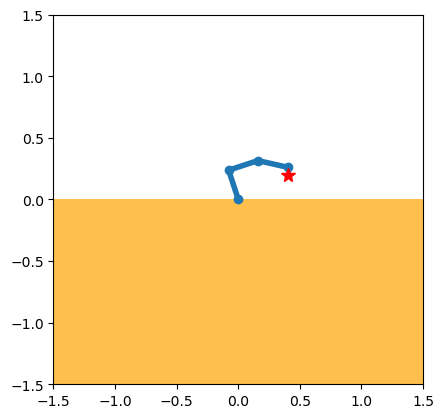

In [12]:
# test operational space controller
if is_opSpace:
    joint_angles = []
    for i in tqdm(range(1000)):
        u = get_operational_space_control(Q_init,Qdot_init)
        Q_init, Qdot_init = explicit_euler(Q_init,Qdot_init,u)
        joint_angles.append(Q_init['joints'])
        if debugger:
            if i%100 == 0:
                print(f'Q: {Q_init}, \nQdot:{Qdot_init}')
                print('end eff: ', forward_kinematics(Q_init,Qdot_init)[0][-1])
                print()

    # animate
    animate(np.array(joint_angles), {'link_lengths': l_links, 'goal': x_op_space_goal}, filename='opSpace')

**Step 5** Write the cost function to perform the block pushing

In [13]:
# define the weight hyperparameters for loss function
W_Q = jnp.eye(2)*10.0
W_Qt = jnp.eye(6)*1e-5
W_u = jnp.eye(3)*0.0

def task_cost(x_block, u):
    return jnp.mean(vmap(lambda _x_block, _u : (_x_block[:2] - xblock_goal[:2]).T@W_Q@(_x_block[:2] - xblock_goal[:2]) \
            + _u.T@W_u@_u)(x_block,u)) + (x_block[-1] - xblock_goal).T@W_Qt@(x_block[-1] - xblock_goal)


def total_cost(_Q_init, _Qdot_init, u):
    # rollout the trajectory, split up the states into new variables
    traj = rollout(_Q_init,_Qdot_init,u)
    Q, Qdot = {k: v[:,:3] for k, v in traj.items()}, {k: v[:,3:] for k, v in traj.items()}
    x_block = jnp.hstack([Q['block'],Qdot['block']])

    return task_cost(x_block, u) \
            + 1e-3*jnp.sum(vmap(signed_distance_function_ee_to_block)(Q,Qdot)**2) \
            + 1e6*jnp.sum(jnp.minimum(0.0,vmap(signed_distance_function_ee_to_ground)(Q,Qdot))**2)

In [14]:
# instantiate the predictive sampler class
caps = CAPS(dt,ctrl_hrzn=25,ctrl_bounds=(torque_min, torque_max),
            pos_bounds=(q_min, q_max), 
            vel_bounds=(qdot_min, qdot_max),
            num_splines=20)

In [15]:
# log
def log_data(stack:dict, data:dict) -> dict:
    stack['Q']['joints'].append(data['Q']['joints'])
    stack['Q']['block'].append(data['Q']['block'])
    stack['Qdot']['joints'].append(data['Qdot']['joints'])
    stack['Qdot']['block'].append(data['Qdot']['block'])
    stack['u'].append(data['u'])
    return stack

# function to update plan
def update_plan_and_keys(sample_nomplans,keys,star):
    # update the nominal plan and keys
    nominal_plan = caps.update_plan(star,sample_nomplans,keys)
    keys = caps.update_keys(star,keys)
    return nominal_plan, keys

# run the controller
def run_pushing_task(Q_init, Qdot_init, T : int = 2000):
    """
    runs the experimental design algo
    """
    # initialize nominal plan and control sampling keys
    nominal_plan = caps.get_init_plan()
    keys = caps.get_init_keys(10)

    # initialize data
    simulator_data = {
        'Q': Q_init,
        'Qdot': Qdot_init,       
        'u': jnp.zeros((2,))
    }

    # initialize the stacks to append to
    sim_stack = {'Q':{'joints': [], 'block': []}, 'Qdot':{'joints': [], 'block': []}, 'u': []}
    
    for t in tqdm(range(T)):
        # get costs and best action from sampled controls from the task and the information measure
        ustar, star, sample_nomplans, _ = caps.get_action(total_cost, keys, nominal_plan, 
                                                          simulator_data['Q'], simulator_data['Qdot'])
        nominal_plan, keys = update_plan_and_keys(sample_nomplans,keys,star)
        
        # apply control to robot - real params
        simulator_data = sim_step(simulator_data['Q'], simulator_data['Qdot'], ustar)

        # print(physics_params)
        sim_stack = log_data(sim_stack,simulator_data)

        if debugger:
            if t%100 == 0:
                print('sdf: ', signed_distance_function_ee_to_block(simulator_data['Q'], simulator_data['Qdot']))
                print('optimality loss: ', jnp.linalg.norm(simulator_data['Q']['block'][:2] - xblock_goal[:2]))

    sim_stack['Q']['joints'] = jnp.array(sim_stack['Q']['joints'])
    sim_stack['Qdot']['joints'] = jnp.array(sim_stack['Qdot']['joints'])
    sim_stack['Q']['block'] = jnp.array(sim_stack['Q']['block'])
    sim_stack['Qdot']['block'] = jnp.array(sim_stack['Qdot']['block'])
    sim_stack['u'] = jnp.array(sim_stack['u'])

    animate(sim_stack['Q']['joints'],{'l_box': l_block, 'link_lengths': l_links, 'goal': xblock_goal}, 
            box_pos=sim_stack['Q']['block'], filename='push_block')
    
    return sim_stack

  0%|          | 1/2000 [00:15<8:30:50, 15.33s/it]

sdf:  [0.16753128]
optimality loss:  0.25


  5%|▌         | 101/2000 [02:34<44:44,  1.41s/it]

sdf:  [0.09752907]
optimality loss:  0.25


 10%|█         | 201/2000 [04:51<42:08,  1.41s/it]

sdf:  [0.022297]
optimality loss:  0.25


 15%|█▌        | 301/2000 [07:11<39:39,  1.40s/it]

sdf:  [0.02349552]
optimality loss:  0.22860342


 20%|██        | 401/2000 [09:33<37:26,  1.40s/it]

sdf:  [0.07052466]
optimality loss:  0.18180561


 25%|██▌       | 501/2000 [11:57<36:10,  1.45s/it]

sdf:  [0.05761549]
optimality loss:  0.14668465


 30%|███       | 601/2000 [14:19<32:48,  1.41s/it]

sdf:  [0.04464231]
optimality loss:  0.12489551


 35%|███▌      | 701/2000 [16:39<30:31,  1.41s/it]

sdf:  [0.03275509]
optimality loss:  0.11334354


 40%|████      | 801/2000 [18:59<28:19,  1.42s/it]

sdf:  [0.02300406]
optimality loss:  0.107533336


 45%|████▌     | 901/2000 [21:21<27:41,  1.51s/it]

sdf:  [0.02618385]
optimality loss:  0.104239285


 50%|█████     | 1001/2000 [23:42<24:12,  1.45s/it]

sdf:  [0.02691082]
optimality loss:  0.10119349


 55%|█████▌    | 1101/2000 [26:07<21:33,  1.44s/it]

sdf:  [0.03729446]
optimality loss:  0.015322387


 60%|██████    | 1201/2000 [28:29<15:55,  1.20s/it]

sdf:  [0.71102196]
optimality loss:  0.67368436


 65%|██████▌   | 1301/2000 [30:52<16:12,  1.39s/it]

sdf:  [1.3226337]
optimality loss:  1.2940235


 70%|███████   | 1401/2000 [33:13<14:09,  1.42s/it]

sdf:  [1.8707658]
optimality loss:  1.8457131


 75%|███████▌  | 1501/2000 [35:36<11:35,  1.39s/it]

sdf:  [2.3530722]
optimality loss:  2.328768


 80%|████████  | 1601/2000 [37:55<09:37,  1.45s/it]

sdf:  [2.7674727]
optimality loss:  2.743198


 85%|████████▌ | 1701/2000 [40:17<07:01,  1.41s/it]

sdf:  [3.1131194]
optimality loss:  3.089052


 90%|█████████ | 1801/2000 [42:35<04:41,  1.42s/it]

sdf:  [3.3905878]
optimality loss:  3.36656


 95%|█████████▌| 1901/2000 [45:02<03:08,  1.90s/it]

sdf:  [3.6006436]
optimality loss:  3.5766106


100%|██████████| 2000/2000 [47:49<00:00,  1.43s/it]


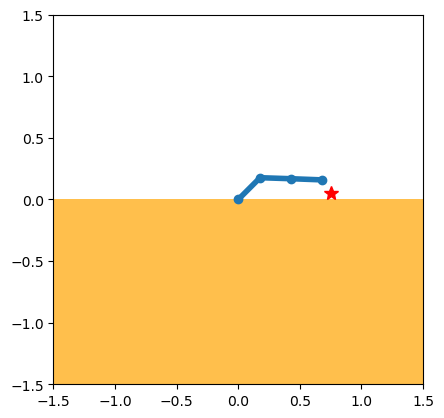

In [16]:
if is_pushblock:

    sim_stack = run_pushing_task(Q_init, Qdot_init, T=2000)